In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiregressor as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
111,6.4,2.7,5.3,1.9,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
133,6.3,2.8,5.1,1.5,Iris-virginica
114,5.8,2.8,5.1,2.4,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
...,...,...,...,...,...
79,5.7,2.6,3.5,1.0,Iris-versicolor
125,7.2,3.2,6.0,1.8,Iris-virginica
19,5.1,3.8,1.5,0.3,Iris-setosa
149,5.9,3.0,5.1,1.8,Iris-virginica


### Prepare dataset 

In [3]:
labels_column_name = "label"
jackknife_idx = random.choice(iris_dataset.index.to_numpy())
# jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-setosa']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5,
    discretize_continuous=False,
    use_inversed_data_for_training=True
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 1.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 0.0}


Explain the instance

array([1., 0., 0.])

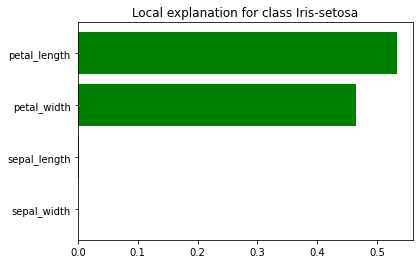

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
28,5.2,3.4,1.4,0.2,Iris-setosa


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[1.0, 0.0, 0.0]
[0.95233655123833, 0.04382038602527398, 0.006227666274894538]
[0.95007104, 0.04371614, 0.006212851]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.0010415  0.00800478 0.00397546]
MSE on cv-test  set: [0.00112815 0.0081717  0.00433973]
std on cv-test  set: [0.00012337 0.00043192 0.00024987]


In [11]:
explanation.get_predicted_label()

'Iris-setosa'

In [12]:
# explanation.render_explanation_tree("../data/img/tree_explanation/tree_multiregressor.png")

In [13]:
print(explanation.get_decision_rules_for_explanation())

Sklasyfikowano jako 'Iris-setosa', ponieważ:
		cecha petal_length (o wartości 1.4) była <= 2.457
	oraz	cecha petal_width (o wartości 0.2) była <= 0.796
	oraz	cecha petal_width (o wartości 0.2) była <= 0.729
	oraz	cecha petal_length (o wartości 1.4) była <= 2.447



In [14]:
explanation.get_fidelity_loss_on_kfold()

array([0.0033956 , 0.00362091, 0.00385517, 0.00406009, 0.00363448])

In [15]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.5328309981377671),
 (3, 0.4656839371788722),
 (0, 0.0014850646833605712),
 (1, 0.0)]

In [16]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.6080766125786424),
 (3, 0.3579231781073292),
 (0, 0.026007180093049087),
 (1, 0.00799302922097924)]

In [17]:
explanation.as_map()

{0: [(2, 0.5328309981377671),
  (3, 0.4656839371788722),
  (0, 0.0014850646833605712),
  (1, 0.0)],
 1: [(2, 0.5496395100916124),
  (3, 0.4492245203117305),
  (0, 0.0007685992630155277),
  (1, 0.0003673703336417461)],
 2: [(2, 0.6080766125786424),
  (3, 0.3579231781073292),
  (0, 0.026007180093049087),
  (1, 0.00799302922097924)]}

In [18]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs

Update some attributes to see if probabilities would change

In [ ]:
top_features = explanation.as_map()[predicted_label_id]
top_features